# The Paper

In [1]:
# Homography from two orientation- and scale-covariant features
# https://openaccess.thecvf.com/content_ICCV_2019/papers/Barath_Homography_From_Two_Orientation-_and_Scale-Covariant_Features_ICCV_2019_paper.pdf


# "... Also, homographies can be estimated from two affine correspondences [17]"
# Affine icin de baskalari yapmis yani. Burada affine degil sadece similarity.

# ORB'da size yok angle var sadece. Bununla ilgili de bir sey yapilabilir mi? (Euclidean)
# 2. sayfanin basinda adi geciyor.
# Ayrica surada da sanki bununla ilgili bir sey geciyor: "First, a homography is obtained from three oriented features."

# Exploiting this additional information is a well-known approach in, for example, wide-baseline matching [23, 26].
# Yet, the first papers [1, 2, 3, 25, 4] involving them into geometric model estimation were published just in the last few years. 
# Bunlari bir incele.

# Bu makalede isime yarayacak 2 sey daha var:
# 1) Table 1 (Efficiency karsilastirmasi yapmak icin)
# 2) Homografi veri kumeleri. (5.3 Real world tests) + USAC makalesinde de veri kumeleri var.
# Ayrica: Figure 4, figure 5, table 2, figure 6 da cok iyi.

# Bu arada bir de MATLAB kaynak kodu var makalede.

# Implementasyon yap ve 4 noktadan bulmayla karsilastir.

# My Ideas

In [2]:
# angle + size

# Aslinda burada yapilan sey basitce her circle icin merkezine ek olarak angle boyunca size/2 kadar ilerleyince bulunun noktayi kullanmak seklinde olmaz mi?
# (Angle ve size icerenlerde 2 noktayi yetirdim. Her iki nokta icin de angle yonundeki cember noktasini da dahil ederim olur biter.)
# Boylece 2 noktadan zaten 2 ekstra nokta bulunuyor, yani 4 nokta oluyorlar.
# Aslinda bu yontem sadece kabaca dogru.
# Cunku aslinda o cemberler tam olarak eslesmiyor. Bir kere cember diger imgede cember olmaz ki. Arada affine bile olsa elips olurdu.
# Ki local olarak affine sayabiliriz. Ama dedigim gibi elips olurdu.
# Local similarity varsayiyoruz biz galiba.
# Herhalde bu yuzden makale bu kadar basit bir yonteme dayanmiyor.

# --------------------------------------------------

# angle

# Kendimce sadece angle'a bakarak 3 noktayi yetirdim. Hatta bu 3 noktadan 1 ekstra nokta degil, 3 ekstra nokta cikarabiliyorum. (Paralellik olmazsa.)
# (Yonleri dogrultu olarak al ve ikili dogrultularin kesisimi diger imgede de kesistigi yerde bulunmak zorunda.)
# (Yalniz bu yontem ufak hatalara karsi cok hassas gibi. Ustelik her iki keypoint'in de dogru olmasi gerekiyor.)
# (Dogrularin dogru kalmasi gercegini kullaniyoruz burada. Bir dogru diger tarafta da dogrudur. Iki dogrunun kesisimi digerinde de ayni dogrularin kesisiminde yer alir.)

# --------------------------------------------------

# size (IPTAL!)

# Sadece size icerenlerde 3 noktayi yetirdim. Hatta 3 ekstra nokta daha bulabiliyorum. Cemberlere teget cizerek tegetlerin kesistigi noktalari aliyorum. (Esit boyutta size olmazsa.)
# Hatta 2 size bile yetiyor gibi. Aralarinda kalan teget kesisimini de katarsak 2 ektra nokta cikiyor.
# Burada terminoloji var: https://www.cut-the-knot.org/Curriculum/Geometry/GeoGebra/TangentToTwoCircles.shtml
# Yani intersection_of_outer_tangents(circle1, circle2) ve intersection_of_inner_tangents(circle1, circle2).
# intersection_of_outer_tangents(circle1, circle2)
#   assert circle1.radius != circle2.radius
#   pass  # Ucgen benzerliginden bulunur. (Cemberlerin caplarını dusunerek ucgen ciz.)
# intersection_of_inner_tangents(circle1, circle2)
#   Buradaki kosul circle'larin kesismemesi. Yani merkezleri arasindaki mesafenin radiuslarin toplamindan buyuk olmasi.
#   Zaten bizim icin bu yeterli. Circle'larimiz kesismez.
#   Ama kesisse bile farkli sekilde baska ozel noktalar bulabilirdik. (Hatta merkezleri ayniysa bile. Ama hem merkezleri hem de yaricaplari ayniysa olmaz.)
#   assert euclidean_distance(*circle1.center, *circle2.center) > circle1.radius + circle2.radius
#   pass  # Bu da sanirim ucgen benzerliginden bulunur.
# Ama ciddi bir problem var. Cunku bu 4 noktanin hepsi dogrusal oluyor. 
# Ama herhangi ucu bile dogrusal olmamasi gerekiyordu galiba. Nasil olacak?
# Belki de bu yuzden 3SCALE veya 2SCALE diye algoritmalar yok.

In [3]:
# Ekstra fikirler:

# Cemberler arasinda similarity transformation falan bulsak kullanisli olur mu?

# Affine correspondence aslinda nedir? Local affine frame nedir?
# Benzer sekilde similarity correspondence falan olabilir mi?

# Setup

In [4]:
from utils import *

import random
import math
import itertools

# Facts

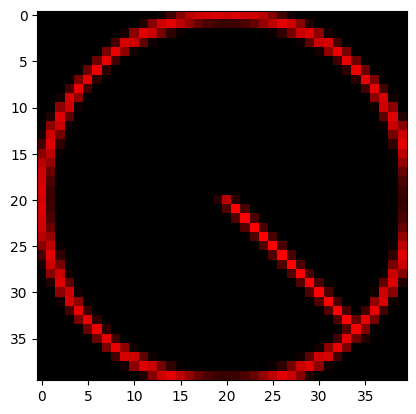

In [5]:
def keypoint_drawing_demo():
    img = np.zeros((40, 40, 3), dtype=np.uint8)

    keypoint = cv.KeyPoint(20, 20, 40, angle=45)
    img_with_kp = cv.drawKeypoints(img, [keypoint], None, color=(0, 0, 255), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # None verilen yere herhangi bir image verilirse (img de dahil) o zaman onun ustune yazar, sonucu atamaya gerek kalmaz.

    show_image(img_with_kp)


keypoint_drawing_demo()
# #################### size aslında diameter!
# #################### angle derece cinsinden. 0 sağa bakıyor. Saat yönünde artıyor!

# "Angle" Implementation

In [6]:
class ParallelLinesException(Exception):
    "Raised when the lines are parallel."
    pass


def get_extra_point_using_angle(keypoint1, keypoint2):
    # angle dogrultusunda dogru ciz her ikisi icin de. Dogrularin kesistigi noktayi bul.
    #assert keypoint1.angle != keypoint2.angle  # Aksi halde ilgili dogrular paralel olur, yani kesismez.

    if keypoint1.angle == keypoint2.angle or keypoint1.angle == keypoint2.angle + 180 or keypoint1.angle == keypoint2.angle - 180:
        raise ParallelLinesException()

    assert keypoint1.angle not in [90, 270]  # Aslinda aksi olabilir ama implementasyonu basit tutalim. TODO: Duzelt. 90 ve 270'in cozumu ayni zaten.
    assert keypoint2.angle not in [90, 270]  # Aslinda aksi olabilir ama implementasyonu basit tutalim. TODO: Duzelt. 90 ve 270'in cozumu ayni zaten.

    x1, y1 = keypoint1.pt
    x2, y2 = keypoint2.pt

    # x increases from left to right.
    # y increases from top to bottom.
    # Angles are 0 at the right, 90 at the bottom, 180 at the left, 270 at the top.

    # We need to find the line equation of the line that passes through (x1, y1) and has the angle keypoint1.angle.

    # y = m * x + n
    # y1 = m * x1 + n
    # y2 = m * x2 + n
    # y1 - y2 = m * (x1 - x2)
    # m = (y1 - y2) / (x1 - x2)
    # n = y1 - m * x1

    m1 = math.tan(math.radians(keypoint1.angle))
    n1 = y1 - m1 * x1

    # We need to find the line equation of the line that passes through (x2, y2) and has the angle keypoint2.angle.

    # y = m * x + n
    # y1 = m * x1 + n
    # y2 = m * x2 + n
    # y1 - y2 = m * (x1 - x2)
    # m = (y1 - y2) / (x1 - x2)
    # n = y1 - m * x1

    m2 = math.tan(math.radians(keypoint2.angle))
    n2 = y2 - m2 * x2

    # Now we have two line equations:
    # y = m1 * x + n1
    # y = m2 * x + n2

    # m1 * x + n1 = m2 * x + n2
    # m1 * x - m2 * x = n2 - n1
    # (m1 - m2) * x = n2 - n1
    # x = (n2 - n1) / (m1 - m2)

    x = (n2 - n1) / (m1 - m2)
    y = m1 * x + n1

    return (x, y)


def get_extra_points_using_angle(keypoints):
    # Her bir ikili icin get_extra_point_using_angle fonksiyonunu cagir, sonuclari biriktirip dondur.
    pts = []
    for keypoint1, keypoint2 in itertools.combinations(keypoints, 2):
        try:
            pt = get_extra_point_using_angle(keypoint1, keypoint2)
            pts.append(pt)
        except ParallelLinesException:
            pass
    pts = np.int32(pts)  # Herhalde yuvarlama falan yapilacak.
    return pts


def get_extra_points_using_angle_consistently(kp1, kp2):
    assert len(kp1) == len(kp2)

    # get_extra_points_using_angle ile ilgili soyle bir problem var:
    # Birinde exception gerceklesirse karsiligini da eklememek lazim yeni noktalara.
    # (Bu durum size + angle durumunda olmuyor. Yeter ki size 0 olmasin. Zaten olmaz. Dolayisiyla orada boyle bir fonksiyona gerek yok.)
    pts1 = []
    pts2 = []
    for idx1, idx2 in itertools.combinations(range(len(kp1)), 2):
        try:
            pt1 = get_extra_point_using_angle(kp1[idx1], kp1[idx2])
            pt2 = get_extra_point_using_angle(kp2[idx1], kp2[idx2])
            
            pts1.append(pt1)
            pts2.append(pt2)
        except ParallelLinesException:
            pass
    pts1 = np.int32(pts1)  # Herhalde yuvarlama falan yapilacak.
    pts2 = np.int32(pts2)  # Herhalde yuvarlama falan yapilacak.
    return pts1, pts2

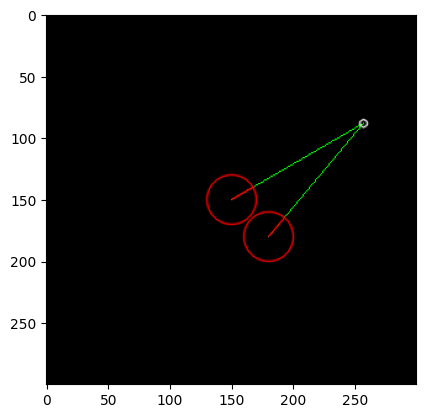

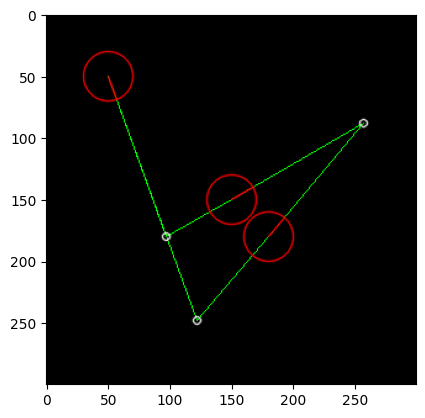

In [7]:
def test_get_extra_point_using_angle():
    draw_lines = True

    angle1 = 330
    angle2 = 310

    img = np.zeros((300, 300, 3), dtype=np.uint8)

    keypoint1 = cv.KeyPoint(150, 150, 40, angle=angle1)
    keypoint2 = cv.KeyPoint(180, 180, 40, angle=angle2)

    pt = get_extra_point_using_angle(keypoint1, keypoint2)
    new_keypoint = cv.KeyPoint(*pt, 10, angle=0)

    if draw_lines:
        cv.line(img, (int(keypoint1.pt[0]), int(keypoint1.pt[1])), (int(new_keypoint.pt[0]), int(new_keypoint.pt[1])), (0, 255, 0), 1)
        cv.line(img, (int(keypoint2.pt[0]), int(keypoint2.pt[1])), (int(new_keypoint.pt[0]), int(new_keypoint.pt[1])), (0, 255, 0), 1)

    cv.drawKeypoints(img, [keypoint1, keypoint2], img, color=(0, 0, 255), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    cv.drawKeypoints(img, [new_keypoint], img, color=(255, 255, 255), flags=cv.DRAW_MATCHES_FLAGS_DEFAULT)

    # red: existing keypoints
    # white: new keypoint (derived from existing keypoints)
    # green: lines connecting existing keypoints to new keypoint (proof)

    show_image(img)


def test_get_extra_points_using_angle():
    draw_lines = True

    angle1 = 330
    angle2 = 310
    angle3 = 70

    img = np.zeros((300, 300, 3), dtype=np.uint8)

    keypoint1 = cv.KeyPoint(150, 150, 40, angle=angle1)
    keypoint2 = cv.KeyPoint(180, 180, 40, angle=angle2)
    keypoint3 = cv.KeyPoint(50, 50, 40, angle=angle3)
    keypoints = [keypoint1, keypoint2, keypoint3]

    new_pts: np.ndarray = get_extra_points_using_angle(keypoints)
    new_keypoints = [cv.KeyPoint(*pt.tolist(), 1, angle=0) for pt in new_pts]

    #pt = get_extra_point_using_angle(keypoint1, keypoint2)
    #new_keypoint = cv.KeyPoint(*pt, 10, angle=0)

    if draw_lines:
        cv.line(img, (int(keypoint1.pt[0]), int(keypoint1.pt[1])), (int(new_keypoints[0].pt[0]), int(new_keypoints[0].pt[1])), (0, 255, 0), 1)
        cv.line(img, (int(keypoint1.pt[0]), int(keypoint1.pt[1])), (int(new_keypoints[1].pt[0]), int(new_keypoints[1].pt[1])), (0, 255, 0), 1)

        cv.line(img, (int(keypoint2.pt[0]), int(keypoint2.pt[1])), (int(new_keypoints[0].pt[0]), int(new_keypoints[0].pt[1])), (0, 255, 0), 1)
        cv.line(img, (int(keypoint2.pt[0]), int(keypoint2.pt[1])), (int(new_keypoints[2].pt[0]), int(new_keypoints[2].pt[1])), (0, 255, 0), 1)

        cv.line(img, (int(keypoint3.pt[0]), int(keypoint3.pt[1])), (int(new_keypoints[1].pt[0]), int(new_keypoints[1].pt[1])), (0, 255, 0), 1)
        cv.line(img, (int(keypoint3.pt[0]), int(keypoint3.pt[1])), (int(new_keypoints[2].pt[0]), int(new_keypoints[2].pt[1])), (0, 255, 0), 1)


    cv.drawKeypoints(img, keypoints, img, color=(0, 0, 255), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    cv.drawKeypoints(img, new_keypoints, img, color=(255, 255, 255), flags=cv.DRAW_MATCHES_FLAGS_DEFAULT)

    # red: existing keypoints
    # white: new keypoints (derived from existing keypoints)
    # green: lines connecting existing keypoints to new keypoints (proof)

    show_image(img)


test_get_extra_point_using_angle()
test_get_extra_points_using_angle()

# "Angle and Size" Implementation

In [8]:
def get_extra_point_using_size_and_angle(keypoint):
    # size ve angle bilgileri olan bir noktadan yeni bir nokta daha bulunur.
    assert keypoint.size > 0
    # keypoint'ten angle yonunde size/2 kadar uzaktaki noktayi dondur. Guzel bir trigonometri egzersizi.
    assert 0 <= keypoint.angle < 360  #  Aksi halde kolayca bu araliga alabiliriz, sorun degil.

    x, y = keypoint.pt
    angle = keypoint.angle
    radius = keypoint.size / 2

    # x increases from left to right.
    # y increases from top to bottom.
    # Angle is 0 at the right, 90 at the bottom, 180 at the left, 270 at the top.
    # (We need to find the point that is radius away from (x, y) and has the angle angle.)

    if angle == 0:
        return (x + radius, y)  # Saga gidiyoruz.
    if angle == 90:
        return (x, y + radius)  # Asagi gidiyoruz.
    if angle == 180:
        return (x - radius, y)  # Sola gidiyoruz.
    if angle == 270:
        return (x, y - radius)  # Yukari gidiyoruz.
        
    if angle < 90:
        # y_delta is positive
        # x_delta is positive
        # tan(angle) = y_delta / x_delta
        # y_delta**2 + x_delta**2 = radius**2

        # So:
        # x_delta = y_delta / tan(angle)
        # So:
        # y_delta**2 + (y_delta / tan(angle))**2 = radius**2
        # So:
        # y_delta**2 + y_delta**2 / tan(angle)**2 = radius**2
        # So:
        # y_delta**2 * (1 + 1 / tan(angle)**2) = radius**2
        # So:
        # y_delta**2 = radius**2 / (1 + 1 / tan(angle)**2)
        # So:
        # y_delta = sqrt(radius**2 / (1 + 1 / tan(angle)**2))  # Because it is positive.

        tan = math.tan(math.radians(angle))
        y_delta = math.sqrt(radius**2 / (1 + 1 / tan**2))
        x_delta = y_delta / tan
        assert y_delta > 0
        assert x_delta > 0
    
    elif angle < 180:
        # y_delta is positive
        # x_delta is negative
        # tan(180 - angle) = -y_delta / x_delta
        # y_delta**2 + x_delta**2 = radius**2

        # So:
        # x_delta = -y_delta / tan(180 - angle)
        # So:
        # y_delta**2 + (-y_delta / tan(180 - angle))**2 = radius**2
        # So:
        # y_delta**2 + y_delta**2 / tan(180 - angle)**2 = radius**2
        # So:
        # y_delta**2 * (1 + 1 / tan(180 - angle)**2) = radius**2
        # So:
        # y_delta**2 = radius**2 / (1 + 1 / tan(180 - angle)**2)
        # So:
        # y_delta = sqrt(radius**2 / (1 + 1 / tan(180 - angle)**2))  # Because it is positive.

        tan = math.tan(math.radians(180 - angle))
        y_delta = math.sqrt(radius**2 / (1 + 1 / tan**2))
        x_delta = -y_delta / tan
        assert y_delta > 0
        assert x_delta < 0

    elif angle < 270:
        # y_delta is negative
        # x_delta is negative
        # tan(angle - 180) = y_delta / x_delta
        # y_delta**2 + x_delta**2 = radius**2

        # So:
        # x_delta = y_delta / tan(angle - 180)
        # So:
        # y_delta**2 + (y_delta / tan(angle - 180))**2 = radius**2
        # So:
        # y_delta**2 + y_delta**2 / tan(angle - 180)**2 = radius**2
        # So:
        # y_delta**2 * (1 + 1 / tan(angle - 180)**2) = radius**2
        # So:
        # y_delta**2 = radius**2 / (1 + 1 / tan(angle - 180)**2)
        # So:
        # y_delta = -sqrt(radius**2 / (1 + 1 / tan(angle - 180)**2))  # Because it is negative.

        tan = math.tan(math.radians(angle - 180))
        y_delta = -math.sqrt(radius**2 / (1 + 1 / tan**2))
        x_delta = y_delta / tan
        assert y_delta < 0
        assert x_delta < 0

    else:
        # y_delta is negative
        # x_delta is positive
        # tan(360 - angle) = -y_delta / x_delta
        # y_delta**2 + x_delta**2 = radius**2

        # So:
        # x_delta = -y_delta / tan(360 - angle)
        # So:
        # y_delta**2 + (-y_delta / tan(360 - angle))**2 = radius**2
        # So:
        # y_delta**2 + y_delta**2 / tan(360 - angle)**2 = radius**2
        # So:
        # y_delta**2 * (1 + 1 / tan(360 - angle)**2) = radius**2
        # So:
        # y_delta**2 = radius**2 / (1 + 1 / tan(360 - angle)**2)
        # So:
        # y_delta = -sqrt(radius**2 / (1 + 1 / tan(360 - angle)**2))  # Because it is negative.

        tan = math.tan(math.radians(360 - angle))
        y_delta = -math.sqrt(radius**2 / (1 + 1 / tan**2))
        x_delta = -y_delta / tan
        assert y_delta < 0
        assert x_delta > 0

    assert abs(y_delta**2 + x_delta**2 - radius**2) < 1e-7
    return (x + x_delta, y + y_delta)
    

def get_extra_points_using_size_and_angle(keypoints):
    # Her bir nokta icin get_extra_point_using_size_and_angle fonksiyonunu cagir, sonuclari biriktirip dondur.
    pts = []
    for keypoint in keypoints:
        pts.append(get_extra_point_using_size_and_angle(keypoint))
    pts = np.int32(pts)  # Herhalde yuvarlama falan yapilacak.
    return pts

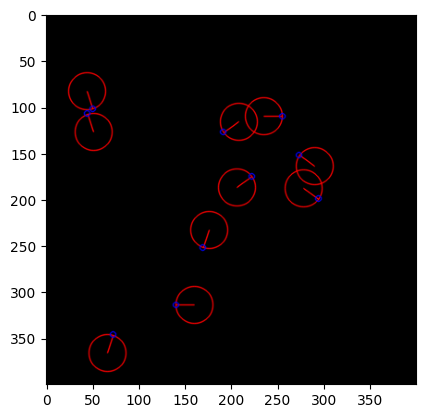

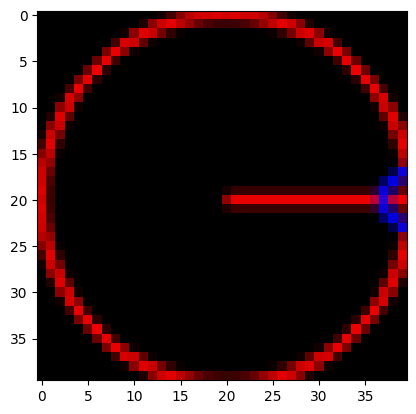

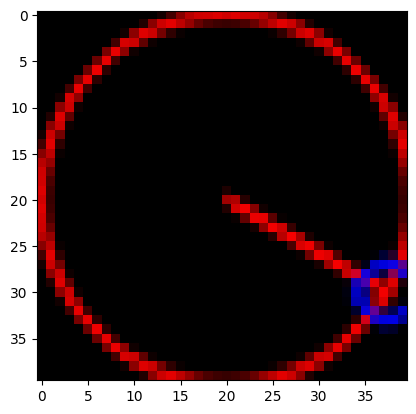

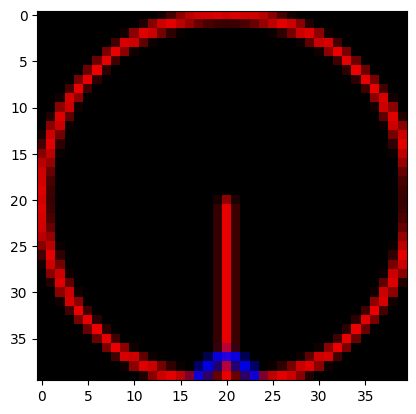

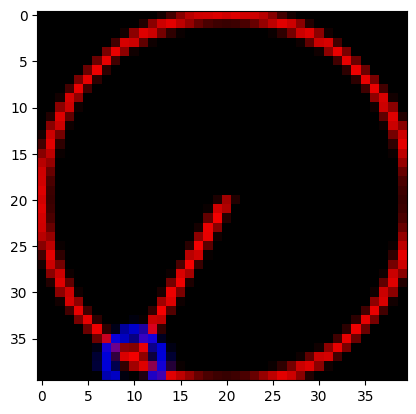

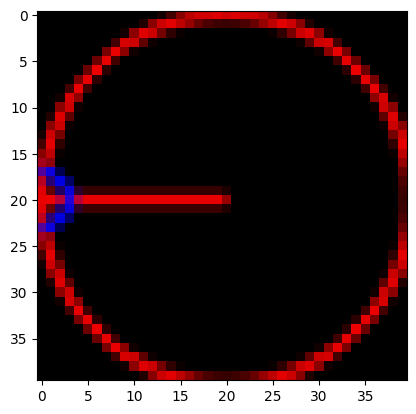

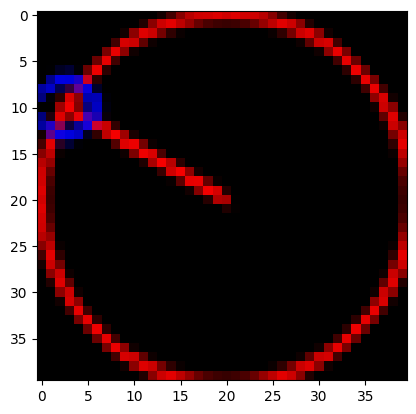

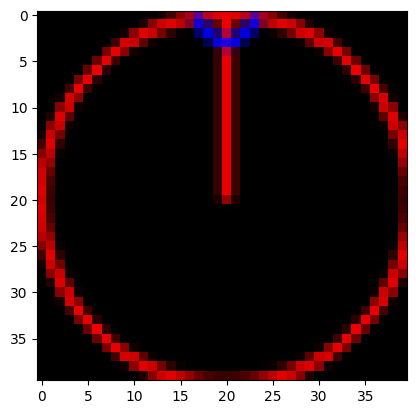

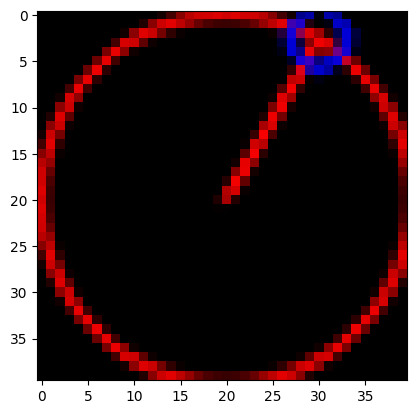

In [9]:
def test_get_extra_point_using_size_and_angle(angle=55):
    img = np.zeros((40, 40, 3), dtype=np.uint8)

    keypoint = cv.KeyPoint(20, 20, 40, angle=angle)

    pt = get_extra_point_using_size_and_angle(keypoint)
    new_keypoint = cv.KeyPoint(*pt, 10, angle=0)

    img_with_kp = cv.drawKeypoints(img, [keypoint], None, color=(0, 0, 255), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img_with_kp = cv.drawKeypoints(img_with_kp, [new_keypoint], None, color=(255, 0, 0), flags=cv.DRAW_MATCHES_FLAGS_DEFAULT)

    show_image(img_with_kp)


def test_get_extra_points_using_size_and_angle():
    keypoint_count = 10

    img = np.zeros((400, 400, 3), dtype=np.uint8)
    kp = [cv.KeyPoint(random.randrange(30, 370), random.randrange(30, 370), 40, angle=angle) for angle in np.linspace(0, 360, keypoint_count, endpoint=False)] 
    pts = get_extra_points_using_size_and_angle(kp)
    new_kp = [cv.KeyPoint(*pt.tolist(), 10, angle=0) for pt in pts]

    cv.drawKeypoints(img, kp, img, color=(0, 0, 255), flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    cv.drawKeypoints(img, new_kp, img, color=(255, 0, 0), flags=cv.DRAW_MATCHES_FLAGS_DEFAULT)

    show_image(img)


test_get_extra_points_using_size_and_angle()

for angle in [0, 30, 90, 120, 180, 210, 270, 300]:
    test_get_extra_point_using_size_and_angle(angle)

# Experiment: Can we use derived points for polishing estimations?

Hypothesis:
- If points are inliers, then derived points are also (probably) inliers (probably more noisy)
- If points are outliers, then derived points are also outliers.

(Results: true for angle and size, false for angle)

In [20]:
# Oncelikle normal bir pipelineda inlier matchleri bulalim (mask'ten). 
# Sonra o inlier olan matchleri kullanarak yeni keypointler ve aralarinda matchler olusturalim.
# Sonra hepsiyle method=0 ile tekrar homography bulalim.
# Eger iyilesme olduysa ne guzel.
# Olmadiysa sikinti.


use_angle_and_size = True  # if False, use only angle. if True, use both angle and size.


img1_no = 1
img2_no = 3


img1_path = f'homography_dataset/img{img1_no}.png'
img2_path = f'homography_dataset/img{img2_no}.png'
h_path = f'homography_dataset/H{img1_no}to{img2_no}p'

img1 = read_image(img1_path, is_grayscale=True)
img2 = read_image(img2_path, is_grayscale=True)

kp1 = detect_keypoints(img1)
kp2 = detect_keypoints(img2)

des1 = compute_descriptors(img1, kp1)
des2 = compute_descriptors(img2, kp2)

bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
matches = bf.match(des1, des2)


matches = matches[:50]  # Burasi tamamen opsiyonel. Bunu kaldirinca da iyilestiriyor. (Az match olunca zaten bulunabiliyorsa iyilestiriyor, bulunamama ihtimali yuksekse kotulestiriyor.)
# O halde aslinda guided matching icin bayagi mantikli olmuyor mu?


pts1 = np.int32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.int32([kp2[m.trainIdx].pt for m in matches])

kp1 = [kp1[m.queryIdx] for m in matches]
kp2 = [kp2[m.trainIdx] for m in matches]

H_estimated1, mask = cv.findHomography(pts1, pts2, method=cv.RANSAC, ransacReprojThreshold=3.0, maxIters=1000)  # maxIters koymayabiliriz ama daha adil bir karsilastirma icin koyalim.

pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

kp1 = [kp1[i] for i in range(len(kp1)) if mask.ravel()[i] == 1]
kp2 = [kp2[i] for i in range(len(kp2)) if mask.ravel()[i] == 1]

print(pts1.shape, pts2.shape)

if use_angle_and_size:
    pts1_extra = get_extra_points_using_size_and_angle(kp1)
    pts2_extra = get_extra_points_using_size_and_angle(kp2)
else:
    pts1_extra, pts2_extra = get_extra_points_using_angle_consistently(kp1, kp2)

pts1 = np.concatenate([pts1, pts1_extra], axis=0)
pts2 = np.concatenate([pts2, pts2_extra], axis=0)

print(pts1.shape, pts2.shape)

H_estimated2, _ = cv.findHomography(pts1, pts2, method=0, ransacReprojThreshold=3.0, maxIters=1000)

if img1_no == img2_no:
    H_true = np.eye(3)
else:
    H_true = np.loadtxt(h_path)

print(round(average_corner_error(img1.shape[0], img1.shape[1], H_true, H_estimated1), 3))
print(round(average_corner_error(img1.shape[0], img1.shape[1], H_true, H_estimated2), 3))

# Oldu :) Sonuclari iyilestiriyor.
# Aslinda genel amacli bir iyilestirme yontemi gibi. Ozellikle de keypoint sayisi azsa. (Kaybedecek bir seyimiz olmayinca.)
# Ayrica eger yeterli sayida match bulunursa en son polish ederken kullanilabilir. Bir bakima guided matching gibi.

# Tabii boyle cok anlamli degil. Dogru olanlari cogaltiyor (ufak hata ekleyerek), yanlis olanlari da tamamen cogaltiyor.
# Minimal solver icin kullanmak mantikli.


# Not: Sadece angle'lari kullanarak butun pairler icin de nokta cogaltma yapilabilir ama gereksiz gibi.
# Ustelik her iki keypointin de dogru olma olasiligi dusuk.
# Ancak minimal solver icin kullanmak mantikli.
# Cunku orada zaten butun sample dogru olmali.


# Ustte yazan yorumlarin tamami size + angle icin gecerli. Sadece angle cok kotu calisiyor.
# TODO: Bir bug varsa gider. Neden bu kadar kotu calissin?
# Mesela kesisim noktasi cok uzaktaysa at gitsin (hata fazladir).

(25, 2) (25, 2)
(50, 2) (50, 2)
67.178
21.137


# Experiment: Can we include derived points in minimal samples?

Daha bitmedi...

In [13]:
def perform_4PT(kp1, kp2):
    assert len(kp1) == 4 and len(kp2) == 4

    pts1 = np.float32([kp.pt for kp in kp1])
    pts2 = np.float32([kp.pt for kp in kp2])
    H = cv.getPerspectiveTransform(pts1, pts2)
    return H  # Degenerate olunca None geliyor galiba. TODO: Bunu kontrol et. 3 tane dogrusal nokta ver. Veya 2 tane ayni nokta verilebilir galiba.


def perform_3ORI(kp1, kp2):
    assert len(kp1) == 3 and len(kp2) == 3
    
    # TODO: ...
    # kp1[0] ile kp1[1] kullanarak yeni bir pt bul. kp2[0] ile kp2[1] kullanarak yeni bir pt bul. Bunlarin eslesmesi lazim.
    # Sonra bu 4 nokta ile H bul.
    # (Eger ParallelLinesException alirsan baska bir ikili kullan. Veya 3 olasi pair'den en mantiklisini kullan. Mesela response'u en yuksek olan 2 tanesini kullan.)
    # (Eger kp1 tarafinda ParallelLinesException yoksa diger tarafta da olmamali. Eger orada olursa baska pair'e gecebiliriz ama aslinda inlier olmadiklari kanitlanmis oluyor, None dondurebiliriz.)
    # (Eger kp1 tarafinda ParallelLinesException varsa bir sonraki pair'e gecilir. Eger hepsi boyleyse o zaman None dondurulur.)


def perform_2SIFT(kp1, kp2):
    assert len(kp1) == 2 and len(kp2) == 2
    pass
    # TODO: ...

# Experiment: Are derived points perfect if given keypoints are perfect?

Daha bitmedi...

In [11]:
# Verilen ground truth H'den sunlari elde edebilmeliyiz:
# 4 tane true correspondence (x, y)
# 3 tane true correspondence (x, y, angle)
# 2 tane true correspondence (x, y, angle, size)

# 4PT, 3ORI, 2SIFT algoritmalarini implement edip orijinal H'yi bulabilmeliyiz.

In [12]:
def get_four_keypoint_matches_with_x_y(H):
    # Get the four keypoint matches with x and y coordinates
    # from the homography matrix H
    # H: 3x3 homography matrix
    # returns: a tuple of these
    #   a list of four keypoints with x and y coordinates
    #   a list of four keypoints with x and y coordinates

    pts1 = np.float32([[0, 0], [0, 1000], [1000, 1000], [1000, 0]])
    kp1 = [cv.KeyPoint(x, y, 1) for x, y in pts1]

    pts2 = cv.perspectiveTransform(pts1.reshape(-1, 1, 2), H).reshape(4, 2)
    kp2 = [cv.KeyPoint(x, y, 1) for x, y in pts2]

    return kp1, kp2


def get_three_keypoint_matches_with_x_y_angle(H):
    pts1 = np.float32([[0, 0], [0, 1000], [1000, 0]])
    angles1 = [45, 300, 105]  # kp1 icin angle cok onemli degil. Yeter ki paralel olmasinlar. kp2 icin karsiliklari hesaplanacak.
    kp1 = [cv.KeyPoint(x, y, 1, angle) for (x, y), angle in zip(pts1, angles1)]

    pts2 = cv.perspectiveTransform(pts1.reshape(-1, 1, 2), H).reshape(4, 2)

    ###
    assert False
    angles2 = None  
    # TODO: kp1[0] ile kp1[1] kullanarak get_extra_point_using_angle ile bir pt bul. 
    # Sonra onu cv.perspectiveTransform ile donustur.
    # Sonra kp2[0]'dan ve kp2[1]'den o noktaya aci hesapla ve angles2 dizisinin ilk 2 elemani bu.
    # Sonra benzer islemi kp1[0] ve kp1[2] ile yap. Bulunan acilardan biri onceden bulunanla ayni olmali (assert), digeri ise angles2 dizisinin 3. elemani olmali. 
    # kp1[1] ve kp2[2] ile ayni islemi yapmaya artik gerek yok. Ama yapilip her iki aci da assert edilebilir.
    ###
    kp2 = [cv.KeyPoint(x, y, 1, angle) for (x, y), angle in zip(pts2, angles2)]

    return kp1, kp2


def get_two_keypoint_matches_with_x_y_angle_size(H):
    pts1 = np.float32([[0, 0], [0, 1000]])
    angles1 = [45, 300]  # Keyfi sayilar
    kp1 = [cv.KeyPoint(x, y, 1, angle) for (x, y), angle in zip(pts1, angles1)]

    pts2 = cv.perspectiveTransform(pts1.reshape(-1, 1, 2), H).reshape(2, 2)
    # TODO: Burada iki sayi var. kp1 kullanarak get_extra_point_using_size_and_angle ile 2 nokta daha bul. Bunlara pt3 ve pt4 diyelim.
    # kp2[0]: pt olarak pts2[0]. size olarak pts2[0] ile pt3 arasindaki mesafenin 2 kati. angle olarak pts2[0]'dan pt3'e olan aci.
    # kp2[1]: pt olarak pts2[1]. size olarak pts2[1] ile pt4 arasindaki mesafenin 2 kati. angle olarak pts2[1]'dan pt4'e olan aci.
    ###
    assert False
    pass

In [14]:
H = np.loadtxt('homography_dataset/H1to6p')

kp1, kp2 = get_four_keypoint_matches_with_x_y(H)
H_estimated = perform_4PT(kp1, kp2)

print(average_corner_error(1000, 1000, H, H_estimated))

0.0


In [15]:
# Sonra kendi RANSAC'imizde normal 4 nokta vs. angle iceren 3 nokta vs. angle ve size iceren 2 nokta dene.

# Bir test vardi onu da unutma. Mukemmel 3 tane SIFT cikar.
# 2 tanesini (ilk ikisini) kullanarak 4 noktaya ulas ve bunlardan cikan homografi mukemmel mi diye bak.
# 3 tanesini kullanarak 6 noktaya ulas ve bunlardan cikan homografi mukemmel mi diye bak.
